In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os

In [3]:
from google.colab import files
files.upload()  # ارفع kaggle (1).json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mloey1/ahcd1
!unzip ahcd1.zip -d ahcd_data

Streaming output truncated to the last 5000 lines.
  inflating: ahcd_data/train images 13440x32x32/train/id_5500_label_16.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5501_label_16.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5502_label_16.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5503_label_16.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5504_label_16.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5505_label_17.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5506_label_17.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5507_label_17.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5508_label_17.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5509_label_17.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_550_label_13.png  
  inflating: ahcd_data/train images 13440x32x32/train/id_5510_label_17.png  
  inflating: ahcd_data/tra

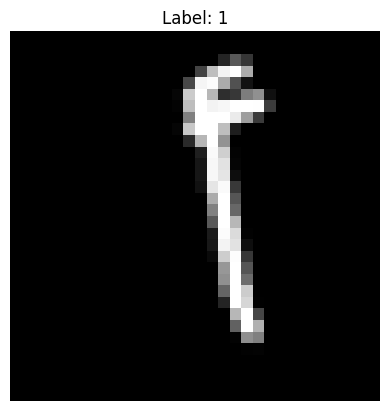

In [4]:
train_images = pd.read_csv("/content/ahcd_data/Arabic Handwritten Characters Dataset CSV/csvTrainImages 13440x1024.csv", header=None)
train_labels = pd.read_csv("/content/ahcd_data/Arabic Handwritten Characters Dataset CSV/csvTrainLabel 13440x1.csv", header=None)

X_train = train_images.values.reshape(-1, 32, 32).astype('float32')

y_train = train_labels.values.squeeze()


plt.imshow(np.fliplr(np.rot90(X_train[5].reshape(32,32), k=3)), cmap='gray')
plt.title(f"Label: {y_train[5]}")
plt.axis('off')
plt.show()


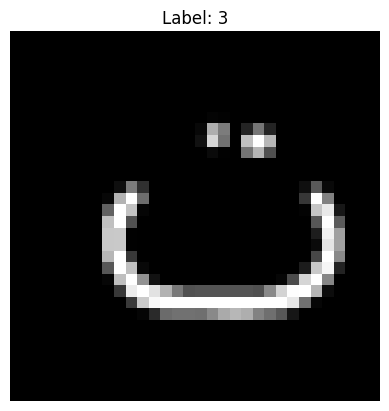

In [5]:
test_images = pd.read_csv("/content/ahcd_data/Arabic Handwritten Characters Dataset CSV/csvTestImages 3360x1024.csv", header=None)
test_labels = pd.read_csv("/content/ahcd_data/Arabic Handwritten Characters Dataset CSV/csvTestLabel 3360x1.csv", header=None)

X_test = test_images.values.reshape(-1, 32, 32).astype('float32')

y_test = test_labels.values.squeeze()

plt.imshow(np.fliplr(np.rot90(X_test[5].reshape(32,32), k=3)), cmap='gray')
plt.title(f"Label: {y_test[5]}")
plt.axis('off')
plt.show()


In [6]:
y_test

array([ 1,  1,  2, ..., 27, 28, 28])

In [7]:
X_train = X_train.reshape(-1, 32, 32, 1)
X_train = X_train / 255.0

X_test = X_test.reshape(-1, 32, 32, 1)
X_test = X_test / 255.0

In [8]:
arabic_letters = {
    1: "ا", 2: "ب", 3: "ت", 4: "ث", 5: "ج", 6: "ح",7: "خ",
    8: "د", 9: "ذ", 10: "ر", 11: "ز", 12: "س", 13: "ش", 14: "ص",
    15: "ض", 16: "ط", 17: "ظ", 18: "ع", 19: "غ", 20: "ف", 21: "ق",
    22: "ك", 23: "ل", 24: "م", 25: "ن", 26: "هـ", 27: "و", 28: "ي"
}


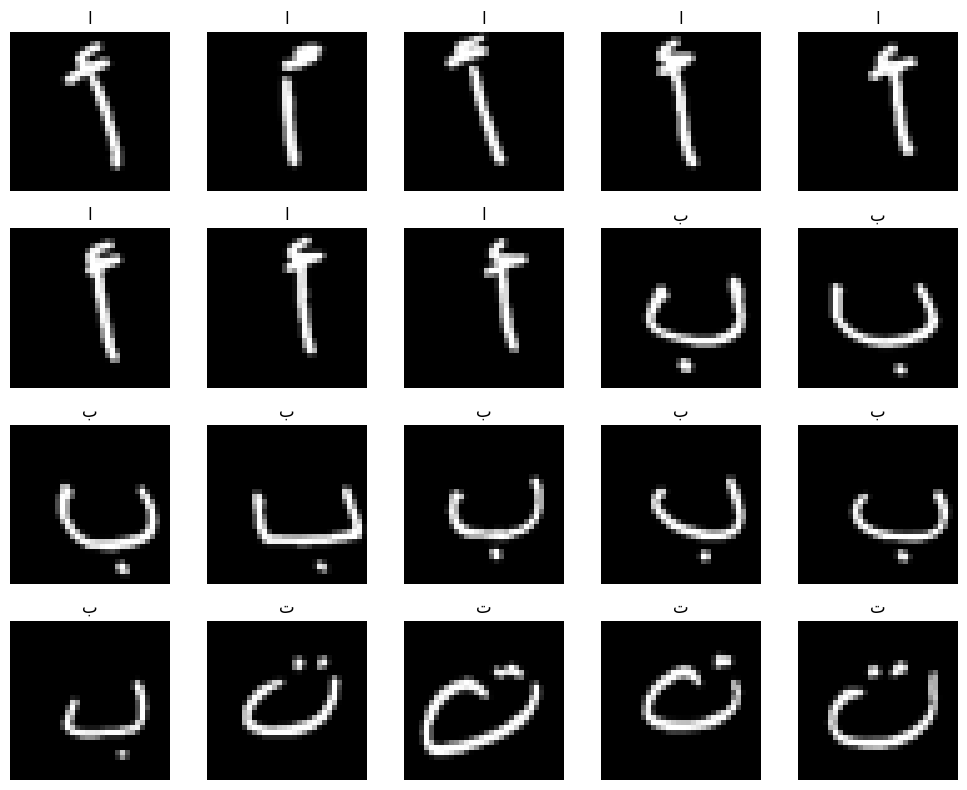

In [9]:
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.fliplr(np.rot90(X_train[i].reshape(32,32), k=3)), cmap='gray')
    plt.title(arabic_letters[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
print("Original X shape:", X_train.shape)
print("Original y shape:", y_train.shape)


Original X shape: (13440, 32, 32, 1)
Original y shape: (13440,)


In [11]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

y_train_cat = to_categorical(y_train - 1, num_classes=28)
y_val_cat = to_categorical(y_val - 1, num_classes=28)
y_test_cat = to_categorical(y_test - 1, num_classes=28)

print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("y_val_cat shape:", y_val_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)


X_train shape: (10752, 32, 32, 1)
y_train_cat shape: (10752, 28)
y_val_cat shape: (2688, 28)
y_test_cat shape: (3360, 28)


In [12]:
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Dense(128, activation='relu'),
    # Dropout(0.5),

    Dense(28, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1210 - loss: 3.2953 - val_accuracy: 0.0357 - val_loss: 8.1188
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4022 - loss: 1.8579 - val_accuracy: 0.0677 - val_loss: 7.6134
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6105 - loss: 1.1494 - val_accuracy: 0.4635 - val_loss: 1.8368
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7236 - loss: 0.8037 - val_accuracy: 0.8225 - val_loss: 0.5574
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8103 - loss: 0.5641 - val_accuracy: 0.8322 - val_loss: 0.4898
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8491 - loss: 0.4433 - val_accuracy: 0.9133 - val_loss: 0.2843
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8843 - loss: 0.3606 - val_accuracy: 0.9129 - val_loss: 0.3263
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9014 - loss: 0.3130 - val_acc

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f'Test Accuracy: {test_acc:.4f}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9448 - loss: 0.2285
Test Accuracy: 0.9485


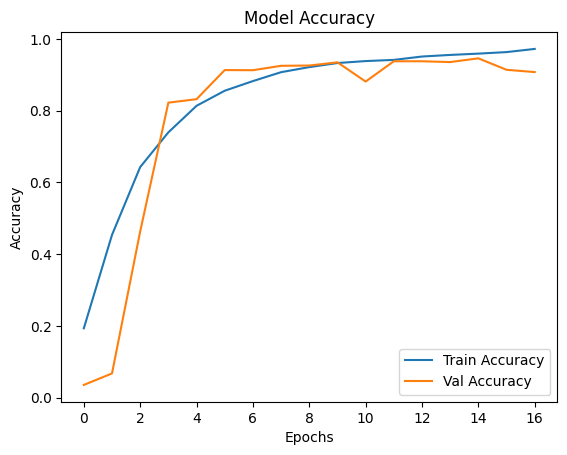

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


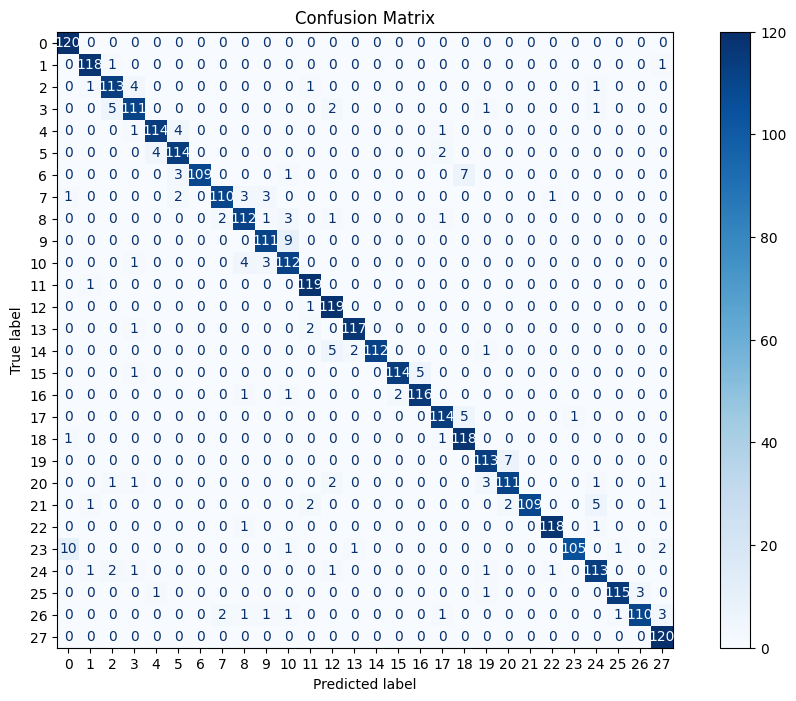

In [17]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()



In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       120
           1       0.97      0.98      0.98       120
           2       0.93      0.94      0.93       120
           3       0.92      0.93      0.92       120
           4       0.96      0.95      0.95       120
           5       0.93      0.95      0.94       120
           6       1.00      0.91      0.95       120
           7       0.96      0.92      0.94       120
           8       0.92      0.93      0.93       120
           9       0.93      0.93      0.93       120
          10       0.88      0.93      0.90       120
          11       0.95      0.99      0.97       120
          12       0.92      0.99      0.95       120
          13       0.97      0.97      0.97       120
          14       1.00      0.93      0.97       120
          15       0.98      0.95      0.97       120
          16       0.96      0.97      0.96       120
          17       0.95    

✅ True Predictions


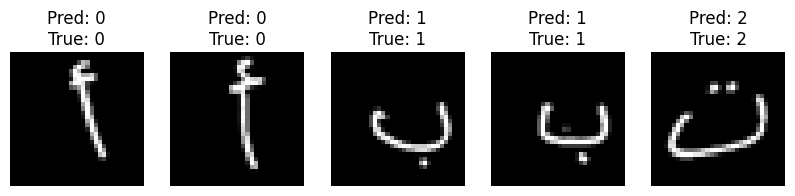

❌ False Predictions


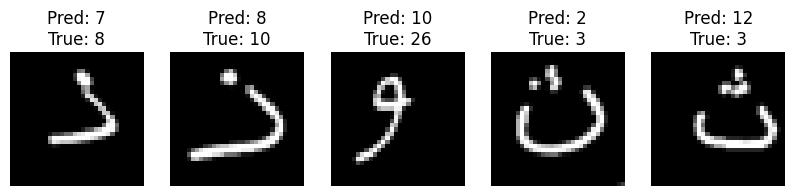

In [19]:
correct = np.where(y_pred == y_true)[0]

incorrect = np.where(y_pred != y_true)[0]


print("✅ True Predictions")
plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.fliplr(np.rot90(X_test[idx].squeeze(), k=3)), cmap='gray')
    plt.title(f"Pred: {y_pred[idx]}\nTrue: {y_true[idx]}")
    plt.axis('off')
plt.show()


print("❌ False Predictions")
plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.fliplr(np.rot90(X_test[idx].reshape(32,32), k=3)), cmap='gray')
    plt.title(f"Pred: {y_pred[idx]}\nTrue: {y_true[idx]}")
    plt.axis('off')
plt.show()


In [20]:
model.save("model.h5")

In [21]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>